# Import Dependencies, Data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pysmiles import read_smiles
import networkx as nx
from rdkit.Chem import AllChem
import torch
import scipy
import rdkit
import os
import pickle

In [5]:
dataframe = pd.read_csv('rev02.csv', delimiter=',')[['Chromophore', 'Emission max (nm)']].dropna()

# Data Exploration

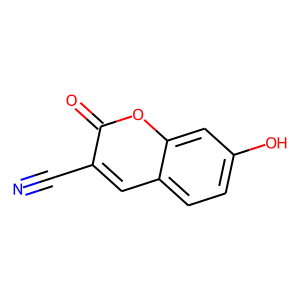

In [4]:
smiles_0 = dataframe['Chromophore'][0]
mol_0 = rdkit.Chem.MolFromSmiles(smiles_0)
rdkit.IPythonConsole.Draw.MolToImage(mol_0)

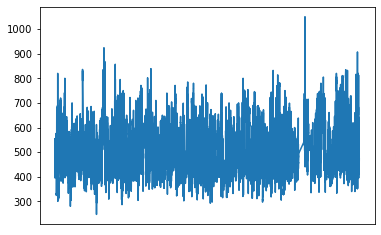

In [6]:
plt.xticks([])
plt.plot(dataframe['Emission max (nm)'])
plt.show()

# Preprocess Data

## Define Constants

In [8]:
MAX_SIZE = 150
atoms = ['C', 'N', 'O', 'F', 'S', 'B', 'Cl', 'Si', 'Br', 'P', 'I', 'Se', '[OOV]']

## TODO: 

* Process Data into proper format: 

### No Need to Re-Run When Finalized!

In [9]:
def to_one_hot(atom): # generate one-hot encodings for an individual atom
  if atom in atoms:
    return [int(atom==valid) for valid in atoms]
  else:
    return [int('[OOV]'==valid) for valid in atoms]

def sparsify(adj_matrix):
  output = [[], []]
  for row in range(adj_matrix.shape[0]):
    for col in range(adj_matrix.shape[1]):
      if adj_matrix[row, col] != 0:
        output[0].append(row); output[1].append(col)
  return torch.LongTensor(output)

def pad_vec(vec_list, target):
  np_arr = np.array(vec_list)
  return np.append(np_arr, np.zeros([target-np_arr.shape[0], np_arr.shape[1]]), axis=0)

def pad_adj(np_adj, target): # also converts to a sparse tensor
  output = np.zeros([target, target])
  output[:np_adj.shape[0], :np_adj.shape[1]] = np_adj
  return sparsify(output)

# GCN Implementation
Concept From: [DeepFindr Article][0]

Other Documentation:
1. [PyTorch Geometric GCN][1]
2. [Kipf and Welling][2]

This network incorporates the torch_geometric implementation of the Graph Convolutional Network outlined by Kipf and Welling to predict emission wavelength based on the SMILES representation of a chromophore.

[0]: https://deepfindr.com/understanding-graph-neural-networks-part-3-3/ "Title"
[1]: https://pytorch-geometric.readthedocs.io/en/latest/notes/create_gnn.html#implementing-the-gcn-layer "Title"
[2]: https://arxiv.org/abs/1609.02907 "Title"

## TODO/FIXME


* Need to incorporate solvent data into network input; currently only using chromophore. :weary:
* Currently discarding stereochemistry details. TODO: implement isomer details in edge_attribute matrix?
* Current graph features are only one-hot encodings of the atoms; may be suboptimal for molecular representation.
* Other Optimizations:
    - Dropouts
    - Better pooling layers
    - Batch norm
    - Hyperparameter tuning

In [10]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, TopKPooling, global_mean_pool as gap, global_max_pool as gmp

In [11]:
# NOTE: data-dependent parameters
output_dim = 1
input_shape = len(atoms)
# NOTE: hyperparameters
embedding_size = 64


class GCN(torch.nn.Module):
  def __init__(self):
    super(GCN, self).__init__()
    
    self.conv0 = GCNConv(input_shape, embedding_size)
    self.conv1 = GCNConv(embedding_size, embedding_size)
    self.conv2 = GCNConv(embedding_size, embedding_size)
    self.conv3 = GCNConv(embedding_size, embedding_size)
    self.out = Linear(embedding_size*2, output_dim)
  
  def forward(self, x, edge_index, batch_index):
    hidden = F.tanh(self.conv0(x, edge_index))
    hidden = F.tanh(self.conv1(hidden, edge_index))
    hidden = F.tanh(self.conv2(hidden, edge_index))
    hidden = F.tanh(self.conv3(hidden, edge_index))
    hidden = torch.cat([gmp(hidden, batch_index), gap(hidden, batch_index)], dim=1)
    out = self.out(hidden)
    return out, hidden

In [12]:
model = GCN()
print(model)

GCN(
  (conv0): GCNConv(13, 64)
  (conv1): GCNConv(64, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (out): Linear(in_features=128, out_features=1, bias=True)
)


# Model Training

In [13]:
from torch_geometric.data import DataLoader, Data
import warnings
warnings.filterwarnings('ignore')

with open('data', 'rb') as file:
  data_dict = pickle.load(file)
  
data = [Data(x=vec, edge_index=adj, y=y) for vec, adj, y in zip(data_dict['xs'], data_dict['edge_indices'], data_dict['ys'])]
  
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

data_size = len(data)
BATCH_SIZE = 64
loader = DataLoader(data[:int(data_size * 0.8)], batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(data[int(data_size * 0.8):], batch_size=BATCH_SIZE, shuffle=True)

In [14]:
def train_step(loader):
  for batch in loader:
    predictions = []
    batch.to(device)
    optimizer.zero_grad()
    pred, embedding = model(batch.x.float(), batch.edge_index, batch.batch)
    predictions.append(pred)
    loss = torch.sqrt(loss_fn(pred, batch.y))
    loss.backward(); optimizer.step()
  return loss, embedding, predictions

In [15]:
print("Starting training...")
losses = []
predictions = []
for epoch in range(800):
    loss, h, pred = train_step(loader)
    losses.append(loss)
    predictions.append(pred)
    if epoch % 100 == 0:
      print(f"Epoch {epoch} | Train Loss {loss}")

Starting training...
Epoch 0 | Train Loss 461.4333801269531
Epoch 100 | Train Loss 97.39575958251953
Epoch 200 | Train Loss 83.67020416259766
Epoch 300 | Train Loss 96.89005279541016
Epoch 400 | Train Loss 94.82485961914062
Epoch 500 | Train Loss 81.7809829711914
Epoch 600 | Train Loss 73.29894256591797
Epoch 700 | Train Loss 102.99604797363281


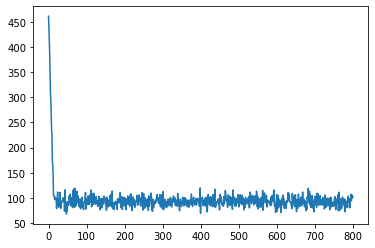

In [23]:
losses_float = [float(loss.cpu().detach().numpy()) for loss in losses] 
loss_indices = [i for i,l in enumerate(losses_float)] 
plt.plot(loss_indices, losses_float)

In [24]:
import pandas as pd 

# Analyze the results for one batch
test_batch = next(iter(test_loader))
with torch.no_grad():
    test_batch.to(device)
    pred, embed = model(test_batch.x.float(), test_batch.edge_index, test_batch.batch) 
    df = pd.DataFrame()
    df["y_real"] = test_batch.y.tolist()
    df["y_pred"] = pred.tolist()
df["y_real"] = df["y_real"].apply(lambda row: row)
df["y_pred"] = df["y_pred"].apply(lambda row: row)
df

,y_real,y_pred
0,474.000000,[493.5452575683594]
1,419.000000,[493.5452575683594]
2,554.000000,[493.5452575683594]
3,520.000000,[493.5452575683594]
4,646.000000,[493.5452575683594]
...,...,...
59,541.000000,[493.5452575683594]
60,420.000000,[493.5452575683594]
61,441.000000,[493.5452575683594]
62,370.454559,[493.5452575683594]


In [25]:
import rdkit
from torch_geometric.datasets import MoleculeNet
 
# Load the ESOL dataset
data_ = MoleculeNet(root=".", name="ESOL")

test = data_[0].edge_index
print(test.shape)

torch.Size([2, 68])


In [27]:
loadme = DataLoader(data_, batch_size=BATCH_SIZE, shuffle=True)

for batch in loadme:
  print(batch.y)
  break

tensor([[-0.8500],
        [-3.3240],
        [-3.9270],
        [-3.3800],
        [-2.6170],
        [-4.0700],
        [-1.3400],
        [ 0.3200],
        [-5.1400],
        [-0.9850],
        [ 0.5400],
        [-4.7550],
        [-0.4100],
        [-3.0400],
        [-2.3100],
        [-3.1500],
        [-5.8390],
        [-1.9500],
        [ 1.0200],
        [-1.7400],
        [-6.4900],
        [-0.4660],
        [-4.8000],
        [-3.2100],
        [-6.1400],
        [-1.8000],
        [-2.9800],
        [-1.9200],
        [-0.9900],
        [-1.2400],
        [-5.8860],
        [-0.4100],
        [-4.8800],
        [-1.9900],
        [-0.3640],
        [-2.0300],
        [ 0.8100],
        [-4.4320],
        [-5.6700],
        [-0.6200],
        [-3.3800],
        [-4.1700],
        [-2.0160],
        [-3.1000],
        [-5.7200],
        [-6.0000],
        [-0.4900],
        [-2.5300],
        [-2.3220],
        [-2.2800],
        [-1.0900],
        [-3.0500],
        [-1.